# Automation of Pulser Streamer
> Snigdhadev and Atanu
>> to automate the Swabian Pulse Streamer 8/2

## Importing Modules and PulseStreamer

In [1]:
import numpy as np
from plotly import graph_objs as go
import inspect,dis,dill
import sys
from time import *
import pulsestreamer
from pulsestreamer import PulseStreamer,findPulseStreamers,OutputState,TriggerStart,Sequence
# from grpc import insecure_channel
# from pulse_streamer_grpc import PulseStreamer
# from enum import Enum
# from Sequence import Sequence

In [2]:
IPaddress = findPulseStreamers(search_serial='')[0][0]
pulser = PulseStreamer(IPaddress)
# pulser.getSerial(),pulser.getFPGAID(),pulser.getHostname(),pulser.getFirmwareVersion()

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0


In [3]:
pulser.getNetworkConfiguration(permanent=False)

{'dhcp': 1,
 'ip': '192.168.0.54',
 'netmask': '255.255.255.0',
 'gateway': '192.168.0.1'}

In [4]:
print(pulser.__dict__)
print(dir(pulser))
hasattr(pulser ,'createSequence')

{'ip_address': '169.254.8.2', 'protocol': 'JSON-RPC', 'client_release': '1.7.0', 'proxy': <tinyrpc.client.RPCProxy object at 0x00000238427A3F90>, '_PulseStreamer__version_1_1_or_higher': True}
['REPEAT_INFINITELY', '_PulseStreamer__stream_binary', '_PulseStreamer__stream_json', '_PulseStreamer__version_1_1_or_higher', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'applyNetworkConfiguration', 'chans_to_mask', 'client_release', 'constant', 'convert_sequence_step', 'createOutputState', 'createSequence', 'dec', 'enc', 'enc_binary', 'forceFinal', 'getAnalogCalibration', 'getClock', 'getDebugRegister', 'getFPGAID', 'getFirmwareVersion', 'getHardwareVersion', 'getHostname', 'getNetwor

True

In [5]:
print(inspect.getsource(pulser.createSequence),inspect.getsourcefile(pulser.createSequence))
# dis.dis(pulser.createSequence)
# dill.source.getsource(pulser.createSequence)

    def createSequence(self): #ToDo parameter for safe communication/sequence creation
        seq = Sequence()
        return seq
 C:\ProgramData\anaconda3\Lib\site-packages\pulsestreamer\jrpc\pulse_streamer_jrpc.py


#### Controling the Pulser Operations 

In [6]:
# pulser.reboot()
pulser.reset()

0

## Creating Patterns and Sequences 

### For Digital Pulses 

###### Pulses

In [7]:
patt1 = [(1*1e9, 0), (1*1e9, 1), (1*1e9, 0), (2*1e9, 1)]
patt2 = [(1*1e9, 0), (1*1e9, 1)]

###### Sequences 

In [8]:
# pulser.constant(([],0,0))

In [9]:
seq = pulser.createSequence()
seq2 = pulser.createSequence()

In [10]:
seq.setDigital([0,3],patt1)
seq2.setDigital(3,patt2)
# seq1.invertDigital(0)

In [11]:
seq3 = seq+seq2

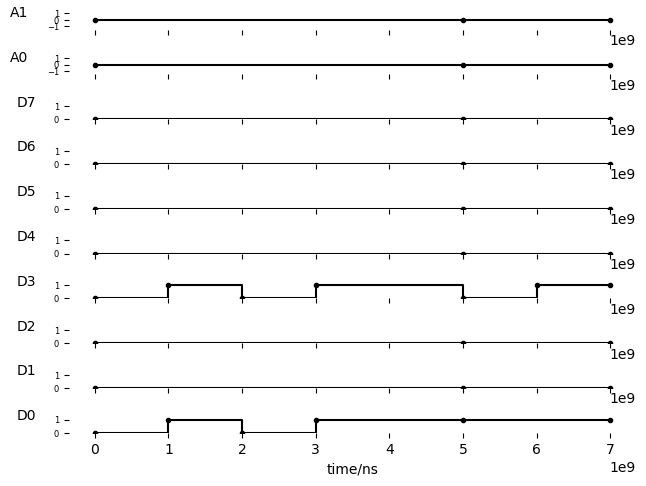

In [12]:
seq3.plot()

In [86]:
seq3.isEmpty(),seq3.getData(),seq3.get_pad(),seq3.getDuration(),seq3.getLastState()
# why the duration values change for seq.getData() while having the two channels involved? 
# what does the getLastState() signify?

(False,
 [(1000000000, 0, 0, 0),
  (1000000000, 9, 0, 0),
  (1000000000, 0, 0, 0),
  (2000000000, 9, 0, 0),
  (1000000000, 1, 0, 0),
  (1000000000, 9, 0, 0)],
 {0: ([(1000000000, 0),
    (1000000000, 1),
    (1000000000, 0),
    (2000000000, 1),
    (2000000000, 1)],
   array([1000000000, 2000000000, 3000000000, 5000000000, 7000000000],
         dtype=int64)),
  1: ([(5000000000, 0), (2000000000, 0)],
   array([5000000000, 7000000000], dtype=int64)),
  2: ([(5000000000, 0), (2000000000, 0)],
   array([5000000000, 7000000000], dtype=int64)),
  3: ([(1000000000, 0),
    (1000000000, 1),
    (1000000000, 0),
    (2000000000, 1),
    (1000000000, 0),
    (1000000000, 1)],
   array([1000000000, 2000000000, 3000000000, 5000000000, 6000000000,
          7000000000], dtype=int64)),
  4: ([(5000000000, 0), (2000000000, 0)],
   array([5000000000, 7000000000], dtype=int64)),
  5: ([(5000000000, 0), (2000000000, 0)],
   array([5000000000, 7000000000], dtype=int64)),
  6: ([(5000000000, 0), (200000

In [92]:
seq3.getLastState()

In [88]:
print(inspect.getsource(seq3.getLastState))

    def getLastState(self):
        """returns last sequence step as OutputState object"""
        ana={}
        digi=[]
        #check if sequence has to be padded
        if not self.__sequence_up_to_date:
            self.__pad()
        for key, pattern_data in self.__pad_seq.items():
            if key < Sequence.digital_channel:
                if (pattern_data[1][-1]):
                    #save digital values if set
                    digi.append(key)
            else:
                #save analog values
                ana.update({'A'+str(key-Sequence.digital_channel):pattern_data[1][-1]})
                
        #create and return OutputState object
        return OutputState(digi, ana['A0'], ana['A1'])



In [45]:
# print(inspect.getsource(seq.get_pad))

In [15]:
# def plotSequence(seq, divisor = 10):
#     dataArray = np.zeros([10,1])
#     for x in seq:
#         chanString = x[1]
#         chanString = '0'*(8-len(bin(x[1])[2:]))+bin(x[1])[2:]
# #         print((chanString))
#         dataHolder = np.zeros([8, int(x[0]/divisor)])
#         an_0 = np.zeros([1, int(x[0]/divisor)])
#         an_1 = np.zeros([1, int(x[0]/divisor)])
#         for i in range(len(chanString)):
#             if chanString[7-i] == '1':
# #                 print(chanString[7-i])
#                 dataHolder[i]+=1.
#         an_0 += x[2]/32767
#         an_1 += x[3]/32767
#         dataHolder = np.concatenate((dataHolder, an_0, an_1), axis = 0)
# #         print(f'dataHolder shape is: {np.shape(dataHolder)}')
#         dataArray = np.concatenate((dataArray, dataHolder), axis = 1)
#         seqPlot = go.FigureWidget()
#         for i in range(len(dataArray[:,0])):
#             if i == 8:
#                 seqPlot.add_scatter(y = dataArray[i],name='Channel '+ 'I')
#             elif i == 9:
#                 seqPlot.add_scatter(y = dataArray[i],name='Channel '+ 'Q')
#             else:
#                 seqPlot.add_scatter(y = dataArray[i],name='Channel '+ str(i))
#     return seqPlot

### For Analog Pulses 

In [ ]:
seqAna = ps.createSequence()

In [ ]:
analog_patt = [( 50, 0), (100, 0.5), (200, 0.3), (50, -0.1), (10, 0)]

In [ ]:
seqAna.setAnalog(0,analog_patt)

## Setting Triggers 

In [ ]:
ps.setTrigger(start=TriggerStart.IMMEDIATE)

## Streaming Sequences

#### Checking Streaming and Triggering Status 

In [ ]:
# pulser.getTriggerStart(),pulser.getTriggerRearm()

In [ ]:
# Sequence.isEmpty(seq1),seq1.getDuration()/1e9,seq1.getLastState(),seq1.getData()

#### Controling Streaming 

In [71]:
pulser.hasSequence(),pulser.isStreaming(),pulser.hasFinished()

(0, 0, 0)

In [75]:
pulser.stream(seq,n_runs=1,final=([],0,0)) 

In [77]:
pulser.reset()

0

In [78]:
pulser.hasSequence(),pulser.isStreaming(),pulser.hasFinished()

(0, 0, 0)

In [70]:
#### how to stream two or more sequences for the channels simultaneously
#### Getting Trigger 
#### Operating on Analog Channels 

In [ ]:
# pulser.stream(seq,n_runs=1,final=([],0,0),start=SOFTWARE)

In [ ]:
# pulser.forceFinal()

In [ ]:
# pulser.startNow()